In [7]:
import os 
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader as Dataloader
from torch.utils.data import Dataset
from PIL import Image


class custom_COVID19_Xray_classic(Dataset):

    """COVID-QU-Ex Dataset object
    Args:
        root (string): Root directory path of dataset.
        train (bool): load either training set (True) or test set (False) (default: True)
        transform: A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform: A function/transform that takes
            in the target and transforms it.
     Attributes:
        samples (list): List of images
        targets (list): The class_index value for each images in the dataset

    """
    def __init__(self, root):
        self.root = root 
        self.classes = os.listdir(self.root)
        self.image_path_list = []
        self.mask_path_list = []
        
        for cls in self.classes:
            for f in os.listdir(os.path.join(self.root,cls,'images')):
                self.image_path_list.append(os.path.join(self.root,cls,'images',f))

            for f in os.listdir(os.path.join(self.root,cls,'lung masks')):
                self.mask_path_list.append(os.path.join(self.root,cls,'lung masks',f))


    def loader(self,path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, segment, target) where target is class_index of the target class.
        """

        image_path = self.image_path_list[index]
        mask_path = self.mask_path_list[index]

        image = np.asarray(self.loader(image_path), dtype = np.uint8)
        mask = np.asarray(self.loader(mask_path), dtype = np.uint8)
        target = np.asarray(self.classes.index(str(os.path.normpath(image_path).replace("\\", "/")).split("/")[-3]), dtype = np.uint8)
        
        
        return image, mask, target
        
    def __len__(self) -> int:
        return len(self.image_path_list)

# Save data into HDF5 format for faster data loading operation

In [8]:
import h5py

traindir = "D:/datasets/COVID_X_ray_dataset_v1/Infection Segmentation Data/Infection Segmentation Data/Train"
valdir = "D:/datasets/COVID_X_ray_dataset_v1/Infection Segmentation Data/Infection Segmentation Data/Val"
testdir = "D:/datasets/COVID_X_ray_dataset_v1/Infection Segmentation Data/Infection Segmentation Data/Test"


train_dataset  = custom_COVID19_Xray_classic(traindir)
val_dataset = custom_COVID19_Xray_classic(valdir)
test_dataset = custom_COVID19_Xray_classic(testdir)


# load the data set using the classic CheXpert
train_loader = Dataloader(train_dataset, batch_size = 256, shuffle = False, num_workers = 0, pin_memory = True)
val_loader = Dataloader(val_dataset, batch_size = 256, shuffle = False, num_workers = 0, pin_memory = True)
test_loader = Dataloader(test_dataset, batch_size = 256, shuffle = False, num_workers = 0, pin_memory = True)


def loader(dataloader):
    images = []
    masks = []
    targets = []
    # put features and labels into arrays
    for batch_ix, (batch_i, batch_m, batch_y) in enumerate(dataloader):
        images.extend(batch_i.numpy())
        masks.extend(batch_m.numpy())
        targets.extend(batch_y.numpy())
    
    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32), np.array(targets,dtype= np.int64)
    


images , masks, targets = loader(train_loader)
root = "data/"
with h5py.File(os.path.join(root,"covid_xray/", "train_3class.hdf5"), 'w') as hf:
    grp = hf.create_group("dataset")
    grp.create_dataset("images",  data=images)
    grp.create_dataset("masks",  data=masks)
    grp.create_dataset("targets",  data=targets)


images , masks, targets = loader(val_loader)
root = "data/"
with h5py.File(os.path.join(root,"covid_xray/", "val_3class.hdf5"), 'w') as hf:
    grp = hf.create_group("dataset")
    grp.create_dataset("images",  data=images)
    grp.create_dataset("masks",  data=masks)
    grp.create_dataset("targets",  data=targets)



images , masks, targets = loader(test_loader)
root = "data/"
with h5py.File(os.path.join(root,"covid_xray/", "test_3class.hdf5"), 'w') as hf:
    grp = hf.create_group("dataset")
    grp.create_dataset("images",  data=images)
    grp.create_dataset("masks",  data=masks)
    grp.create_dataset("targets",  data=targets)

In [9]:
import os
import torch
from torch.utils.data import Dataset
import PIL.Image as Image
import random
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode
import h5py


class COVID19_Xray(Dataset):

    def __init__(self, root_dir, split_type="train", flip=False, resize = None, scale= None, crop=None, brightness = False, rotation = False, random_crop = False):
        
        self.flip = flip
        self.scale = scale
        self.resize = resize
        self.crop = crop
        self.root_dir = root_dir
        self.rotation = rotation
        self.brightness = brightness
        self.random_crop = random_crop

        self.split_type = split_type
       
        with h5py.File(os.path.join(self.root_dir, self.split_type+"_3class.hdf5"), 'r') as hf:
            self.targets = hf["dataset"]["targets"][:]
            self.images = hf["dataset"]["images"][:]
            self.masks = hf["dataset"]["masks"][:]

    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):

        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
         
        index = int(idx)
        image, mask, target = self.images[index], self.masks[index],self.targets[index]
    

        image = (torch.tensor(image, dtype = torch.float32)).unsqueeze(0)
        mask = (torch.tensor(mask, dtype = torch.float32)).unsqueeze(0)
        target = torch.tensor(target)
        
        image, mask = preprocess(image, mask, flip= self.flip, resize= self.resize, crop= self.crop, rotation = self.rotation, brightness = self.brightness, random_crop= self.random_crop)

        image = image/255.
        mask = mask/255.
        
        # normalize the image 
        image = (image-0.5)/0.5
        
        return  image, mask, target
      


def preprocess(image, mask, flip=False, resize = None, crop=None, rotation = False, brightness = False, random_crop = False):

    if crop:
        image = F.center_crop(image,crop)
        mask = F.center_crop(mask,crop)
     
    if resize:
        image = F.resize(image, size= resize, interpolation =InterpolationMode.BILINEAR, antialias = True)
        mask = F.resize(mask, size= resize, interpolation =InterpolationMode.NEAREST, antialias = False)
     

    if random_crop:
        _,h,w = mask.shape
        
        if random.random() < 0.5:
            new_size = random.uniform(h-10,h-5)
            image = F.center_crop(image,new_size)
            mask = F.center_crop(mask,new_size)

        # make sure to resize back to the original size
        image = F.resize(image, size= (h,w), interpolation =InterpolationMode.BILINEAR, antialias = True)
        mask = F.resize(mask, size= (h,w), interpolation =InterpolationMode.NEAREST, antialias = False)
        
    if flip:
        if random.random() < 0.5:
            image = F.hflip(image)
            mask =F.hflip(mask)

    if rotation:
        if random.random() < 0.5:
            degree = random.uniform(-20,20)
            image = F.rotate(image, degree, interpolation = InterpolationMode.BILINEAR)
            mask = F.rotate(mask, degree, interpolation = InterpolationMode.NEAREST)

    return image, mask
   

# Load and visualize

In [10]:
train_dataset =  COVID19_Xray("data/covid_xray/", split_type ="train", resize= 0, crop = 0, flip = True, brightness = True, rotation = False, random_crop= False)
trainloader = Dataloader(train_dataset, batch_size = 64, shuffle = True)

def loader(dataloader, flag = "numpy"):
    images = []
    masks = []
    targets = []
    # put features and labels into arrays
    for batch_ix, (batch_i, batch_m, batch_y) in enumerate(dataloader):
        images.extend(batch_i.numpy())
        masks.extend(batch_m.numpy())
        targets.extend(batch_y.numpy())
    if flag == "numpy":
        return np.array(images), np.array(masks), np.array(targets)
    else:
        return torch.Tensor(images), torch.Tensor(masks), torch.Tensor(targets).long()

train_images, train_masks, train_labels=  loader (trainloader, flag = "torch") 

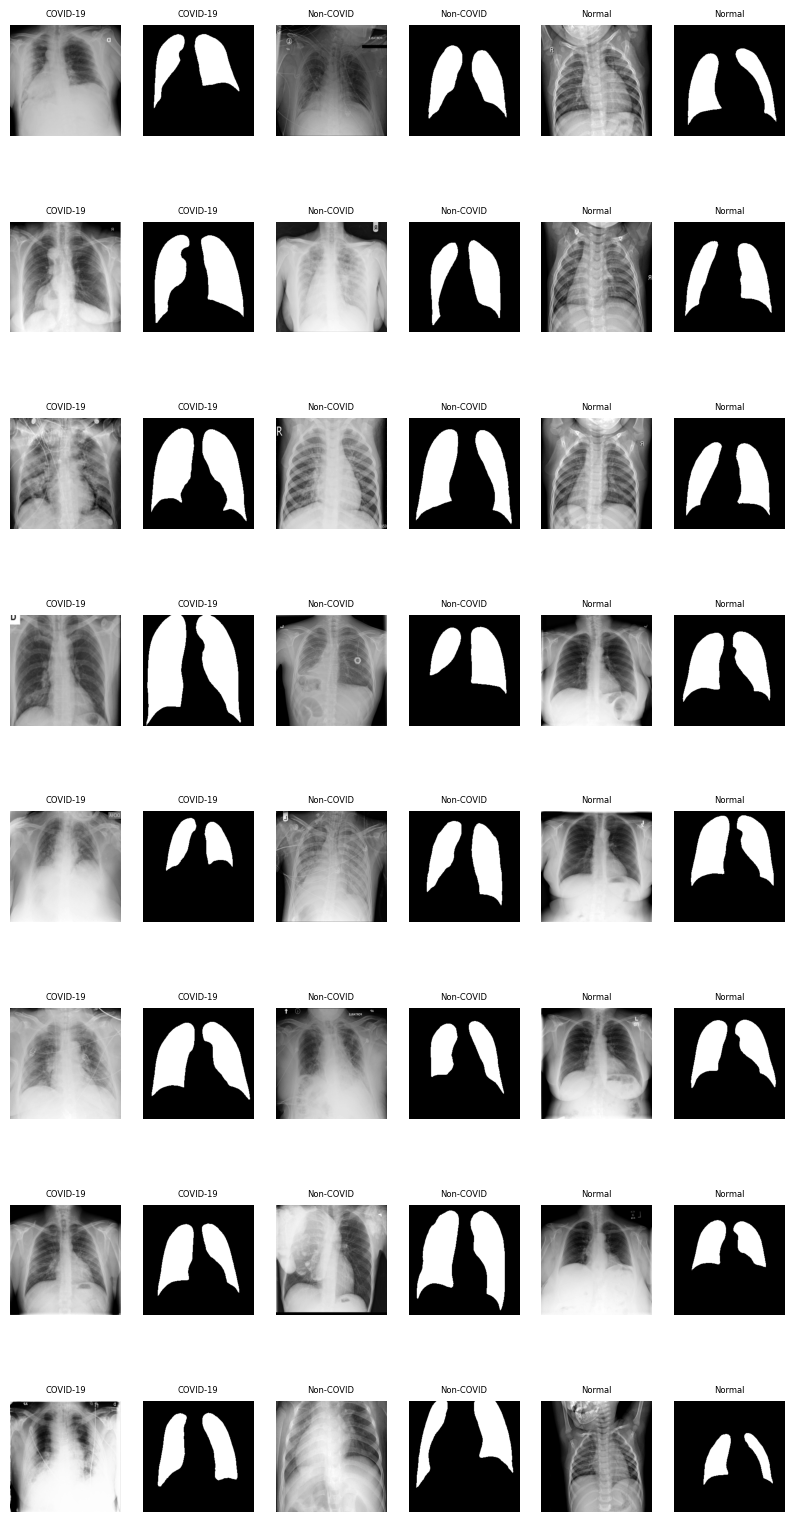

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(8,6, figsize = (10,20))

classes = ['COVID-19', 'Non-COVID', 'Normal']
for i in range(3):
    images = train_images[train_labels == i]
    masks = train_masks[train_labels == i]

    for j in range(8):
        ax[j,2*i].imshow(np.transpose(images[j],(1,2,0)),cmap ="gray")
        ax[j,2*i].set_axis_off()
        ax[j,2*i].set_title(classes[i])

        ax[j,2*i+1].imshow(np.transpose(masks[j],(1,2,0)),cmap ="gray")
        ax[j,2*i+1].set_axis_off()
        ax[j,2*i+1].set_title(classes[i])